#MIT License
Copyright <YEAR> <COPYRIGHT HOLDER>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

costed12@gmail.com

Original dataset from https://s3-us-west-2.amazonaws.com/rm-exercise/rm_topic_modeling_data.zip

Extensively references example notebooks from: https://github.com/derekgreene/topic-model-tutorial

In [2]:
raw_documents = []
snippets = []
with open("topic_modeling_data.json" ,"r") as fin:
    for line in fin.readlines():
        #split line based on first comma
        uid,txt=line.split(",",1)
        #append text element
        txt2=txt[9:(-2)]
        text = txt2.strip()
        raw_documents.append( text )
        #append uid element 
        snippets.append(uid)

print("Read %d raw text documents" % len(raw_documents))

Read 1837 raw text documents


In [3]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 1837 X 5901 document-term matrix


In [5]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 5901 distinct terms


In [6]:
from sklearn.externals import joblib
joblib.dump((A,terms,snippets), "data-raw.pkl") 

['data-raw.pkl']

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 1837 X 5901 TF-IDF-normalized document-term matrix


In [8]:
# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 5901 distinct terms


In [9]:
import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [10]:
ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. casino (167.33)
02. bonus (165.10)
03. deposit (156.72)
04. free (146.45)
05. download (137.27)
06. spins (95.51)
07. play (94.56)
08. de (93.77)
09. mp3 (82.04)
10. players (77.63)
11. descargar (75.73)
12. online (70.54)
13. slot (66.89)
14. games (66.86)
15. slots (60.00)
16. computer (59.66)
17. video (55.34)
18. windows (52.81)
19. account (50.96)
20. wagering (49.07)


In [11]:
joblib.dump((A,terms,snippets), "data-tfidf.pkl") 

['data-tfidf.pkl']

In [12]:
from sklearn.externals import joblib
(A,terms,snippets) = joblib.load( "data-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 1837 X 5901 document-term matrix


In [13]:
k=13 #selected based off results of Parameter_Selection-RM

In [14]:
# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

In [15]:
W.shape

(1837, 13)

In [17]:
# round to 2 decimal places for display purposes
W[0,:].round(2)


array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.41, 0.  ,
       0.  , 0.  ])

In [18]:
#this is the creation of the desired output of:
#: {"_id": "abcdef", "topics": ["topic1", "topic2", "topic3", "topic4", "topic5”]}
with open("output_file.txt", "w") as myfile:
    #for each item in snippets
    for n in range(len(snippets)):
        #create topicList
        topicList=list(reversed([b[0] for b in sorted(enumerate(W[n,:]),key=lambda i:i[1])]))
        
        #output relevant information
        myfile.write('%s, "topics": ["topic%01d", "topic%01d", "topic%01d", "topic%01d",  "topic%01d"]}\n' 
      % (snippets[n], topicList[0]+1, topicList[1]+1,topicList[2]+1,topicList[3]+1,topicList[4]+1))
        myfile.write('')

In [19]:
H.shape

(13, 5901)

In [20]:
import numpy as np
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

In [21]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 5) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: deposit, bonus, players, 2nd, claimed
Topic 02: download, mp3, free, songs, music
Topic 03: de, descargar, gratis, para, en
Topic 04: option, browser, webmail, script, click
Topic 05: deposit, slot, machine, free, spins
Topic 06: casino, account, players, right, reserves
Topic 07: prevent, computer, logins, disabled, call
Topic 08: securetrade, issued, rolla, cookie, rewards
Topic 09: play, slots, video, live, blackjack
Topic 10: technicians, immediate, assistance, windows, certified
Topic 11: bonus, toprated, games, 250, comes
Topic 12: alert, window, activity, key, computer
Topic 13: casino, online, casinos, games, betting


In [22]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [23]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

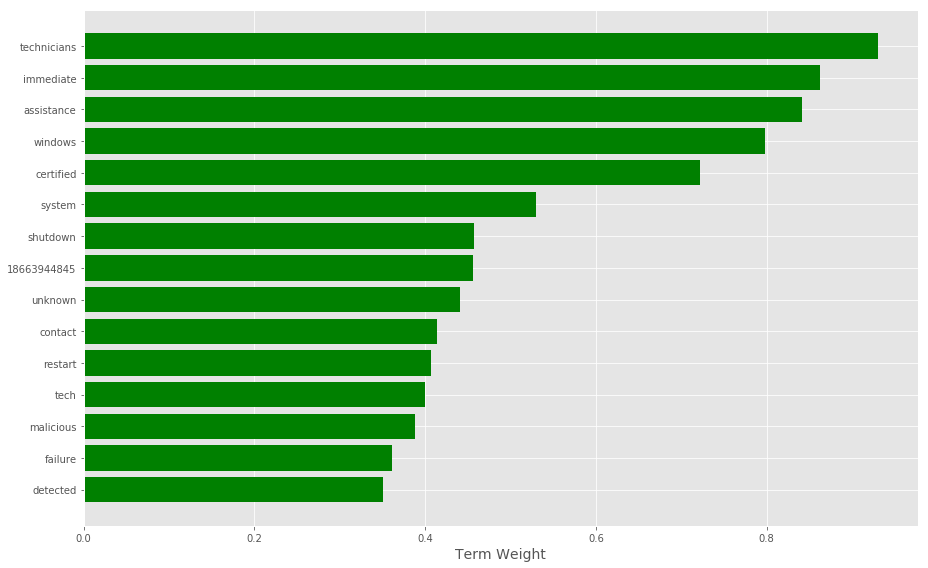

In [24]:
topicNum=10
plot_top_term_weights( terms, H, topicNum-1, 15 )